In [1]:
import csv


csv_file_path = "en-fr.csv"


with open(csv_file_path, "r", encoding="utf-8") as file:
    csv_reader = csv.reader(file)
    num_lines_to_print = 5  # Adjust this value as needed
    for i, row in enumerate(csv_reader):
        if i >= num_lines_to_print:
            break
        print(row)


['en', 'fr']
['Changing Lives | Changing Society | How It Works | Technology Drives Change Home | Concepts | Teachers | Search | Overview | Credits | HHCC Web | Reference | Feedback Virtual Museum of Canada Home Page', 'Il a transformé notre vie | Il a transformé la société | Son fonctionnement | La technologie, moteur du changement Accueil | Concepts | Enseignants | Recherche | Aperçu | Collaborateurs | Web HHCC | Ressources | Commentaires Musée virtuel du Canada']
['Site map', 'Plan du site']
['Feedback', 'Rétroaction']
['Credits', 'Crédits']


In [2]:
import pandas as pd
import re


def english_preprocessing(data, col):
    data[col] = data[col].astype(str)
    data[col] = data[col].apply(lambda x: x.lower())
    data[col] = data[col].apply(lambda x: re.sub("[^A-Za-z\s]", "", x))
    data[col] = data[col].apply(lambda x: re.sub("\s+", " ", x))
    data[col] = data[col].apply(lambda x: " ".join([word for word in x.split()]))
    return data

def french_preprocessing(data, col):
    data[col] = data[col].astype(str)
    data[col] = data[col].apply(lambda x: x.lower())
    data[col] = data[col].apply(lambda x: re.sub(r'\d', '', x))
    data[col] = data[col].apply(lambda x: re.sub(r'\s+', ' ', x))
    data[col] = data[col].apply(lambda x: re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,।]", "", x))
    data[col] = data[col].apply(lambda x: x.strip())
    data[col] = "<sos> " + data[col] + " <eos>"
    return data

data = pd.read_csv('en-fr.csv')

data = english_preprocessing(data, 'en')
data = french_preprocessing(data, 'fr')


print(data.head())


                                                  en  \
0  changing lives changing society how it works t...   
1                                           site map   
2                                           feedback   
3                                            credits   
4                                            franais   

                                                  fr  
0  <sos> il a transformé notre vie  il a transfor...  
1                           <sos> plan du site <eos>  
2                            <sos> rétroaction <eos>  
3                                <sos> crédits <eos>  
4                                <sos> english <eos>  


In [3]:
data["en_len"] = [len(text.split()) for text in data.en]
data['fr_len'] = [len(text.split()) for text in data.fr]


In [4]:
data = data[~(data['en_len'] < 5) & ~(data['en_len'] > 20)]
data = data[~(data['fr_len'] < 5) & ~(data['fr_len'] > 20)]


In [5]:
data.head()


,en,fr,en_len,fr_len
7,the sky of the first inhabitants a contemporar...,<sos> le ciel des premiers habitants la vision...,15,15
12,astronomers introduction introduction video wh...,<sos> astronomes introduction vidéo d'introduc...,7,9
14,the name is derived from the greek root astron...,<sos> son nom vient du grec astron qui veut di...,17,18
18,it prompts us to ask the deepest existential q...,<sos> l'astronomie évoque donc aussi les grand...,9,12
22,the lure of these universal enigmas was the sp...,<sos> l'attrait exercé par ces énigmes univers...,19,18


In [8]:
# reduced dataset  : adjust with resources
english_sentences = data['en'].tolist()[:200000]
french_sentences = data['fr'].tolist()[:200000]


In [9]:
for i in range(495,505):
    print("English:", english_sentences[i])
    print("French:", french_sentences[i])
    print()


English: the first refracting telescopes consisted of two lenses separated by some distance within a closed tube
French: <sos> les premières lunettes astronomiques se composent de deux lentilles disposées de part et d'autre d'un tube fermé <eos>

English: it is the glass of the lens that allows light to be concentrated
French: <sos> on parvient à concentrer la lumière en un point grâce au verre dont sont faites les lentilles <eos>

English: this phenomenon is known as refraction
French: <sos> on donne à ce phénomène de déviation le nom de « réfraction » <eos>

English: there are several types of aberrations the main ones being chromatic and spherical
French: <sos> les principaux sont l’aberration chromatique et l’aberration sphérique <eos>

English: all types of aberration cause deformation of the image transmitted by the telescope
French: <sos> chacun a pour résultat de déformer l’image qu’une lunette transmet <eos>

English: consequently it is impossible to concentrate the rays into 

In [10]:
#english_sentences=english_sentences[:20000]
#french_sentences=french_sentences[:20000]
print(len(english_sentences))

200000


In [11]:
# tokenize sentences
english_tokenized = [[word.lower() for word in sentence.split()] for sentence in english_sentences]
french_tokenized = [[word.lower() for word in sentence.split()] for sentence in french_sentences]
print(english_tokenized[500])
print(french_tokenized[500])

['consequently', 'it', 'is', 'impossible', 'to', 'concentrate', 'the', 'rays', 'into', 'a', 'single', 'point']
['<sos>', 'le', 'résultat', 'est', 'une', 'image', 'bordée', 'de', 'franges', 'de', 'couleurs', 'différentes', '<eos>']


In [12]:
len(english_tokenized), len(english_sentences)


(200000, 200000)

In [13]:
# concatenate all tokenized sentences into a single list
all_words = []
for sentence in english_tokenized + french_tokenized:
    all_words.extend(sentence)

# Get unique words
list_of_words = list(set(all_words))

In [14]:
len(list_of_words)

113234

In [15]:
# vocabulary:  all unique words present in the tokenized English and French sentences 
##==> len of input and output sequences 
english_vocab = set(word for sentence in english_tokenized for word in sentence)
french_vocab = set(word for sentence in french_tokenized for word in sentence)
print(len(english_vocab))
print(len(french_vocab))

60765
81399


-  creates dictionaries that map words to unique integer indices for both English and French vocabularies ==>  converting words to their corresponding indices during model training and inference.

In [16]:
# word-to-index dictionaries
english_word2idx = {word: idx + 1 for idx, word in enumerate(english_vocab)}
french_word2idx = {word: idx + 1 for idx, word in enumerate(french_vocab)}

# Add special tokens for padding and unknown words
PAD_TOKEN = 0
UNK_TOKEN = len(english_word2idx) + 1
english_word2idx['<PAD>'] = PAD_TOKEN
english_word2idx['<UNK>'] = UNK_TOKEN
french_word2idx['<PAD>'] = PAD_TOKEN
french_word2idx['<UNK>'] = UNK_TOKEN


In [24]:
english_idx2word = {idx: word for word, idx in english_word2idx.items()}
french_idx2word = {idx: word for word, idx in french_word2idx.items()}

In [25]:
# Words to indices and pad sequences
max_seq_length = 20
english_indices = [[english_word2idx.get(word, UNK_TOKEN) for word in sentence] for sentence in english_tokenized]
french_indices = [[french_word2idx.get(word, UNK_TOKEN) for word in sentence] for sentence in french_tokenized]
english_padded = [sequence[:max_seq_length] + [PAD_TOKEN] * (max_seq_length - len(sequence)) for sequence in english_indices]
french_padded = [sequence[:max_seq_length] + [PAD_TOKEN] * (max_seq_length - len(sequence)) for sequence in french_indices]


In [ ]:
print("English Word to Index Dictionary:")
print(english_word2idx)

print("\nFrench Word to Index Dictionary:")
print(french_word2idx)

# Print padded sequences
print("\nPadded English Sequence:")
print(english_padded[0])

print("\nPadded French Sequence:")
print(french_padded[0])


- minor check how a sentence looks when transfomed to a sequence of numbers/indices

In [27]:
print(english_sentences[500])
print(english_tokenized[500])
print(english_indices[500])
print(english_padded[500]) ##  model input 

consequently it is impossible to concentrate the rays into a single point
['consequently', 'it', 'is', 'impossible', 'to', 'concentrate', 'the', 'rays', 'into', 'a', 'single', 'point']
[49954, 28795, 38478, 3223, 43360, 49532, 50793, 13408, 22921, 18993, 5241, 15098]
[49954, 28795, 38478, 3223, 43360, 49532, 50793, 13408, 22921, 18993, 5241, 15098, 0, 0, 0, 0, 0, 0, 0, 0]


In [28]:
print(french_sentences[500])
print(french_tokenized[500])
print(french_indices[500])
print(french_padded[500]) ##  model target 

<sos> le résultat est une image bordée de franges de couleurs différentes <eos>
['<sos>', 'le', 'résultat', 'est', 'une', 'image', 'bordée', 'de', 'franges', 'de', 'couleurs', 'différentes', '<eos>']
[60329, 20873, 9787, 68074, 28824, 16556, 31214, 7180, 42579, 7180, 49461, 17679, 4686]
[60329, 20873, 9787, 68074, 28824, 16556, 31214, 7180, 42579, 7180, 49461, 17679, 4686, 0, 0, 0, 0, 0, 0, 0]


- check: reverse the process of converting words to indices and padding sequences.  

In [29]:
# Convert indices to words for the first sentence
english_sentences_unpadded = [english_idx2word[idx] for idx in english_padded[100] if idx != PAD_TOKEN]
french_sentences_unpadded = [french_idx2word[idx] for idx in french_padded[100] if idx != PAD_TOKEN]

# Print the original sentences
print("Original English Sentence:")
print(' '.join(english_sentences_unpadded))

print("\nOriginal French Sentence:")
print(' '.join(french_sentences_unpadded))


Original English Sentence:
observatories ontarios sudbury neutrino observatory is established

Original French Sentence:
<sos> observatoires création de l’observatoire de neutrinos de sudbury en ontario <eos>


In [30]:
import torch
# convert to PyTorch tensors ==> LSTM sequence to sequence prediction
english_tensor = torch.tensor(english_padded)
french_tensor = torch.tensor(french_padded)
print(english_tensor.shape)

torch.Size([200000, 20])


##### To summrize, we maps the origianl sentences to the following tokenized sentences:
- Sentence 1: [10, 1, 2, 0, 0, 0] -> ['i', 'am', 'hungry.', 'PAD', 'PAD', 'PAD']
- Sentence 2: [3, 5, 6, 0, 0, 0] -> ['how', 'are', 'you?', 'PAD', 'PAD', 'PAD']
- Sentence 3: [4, 8, 7, 9, 0, 0] -> ['what', 'is', 'your', 'name?', 'PAD', 'PAD'] 
- etc.

In [31]:
source_sentence = [english_idx2word[idx] for idx in english_tensor[500].tolist() if idx != PAD_TOKEN]
print("Source sequence:", source_sentence)


Source sequence: ['consequently', 'it', 'is', 'impossible', 'to', 'concentrate', 'the', 'rays', 'into', 'a', 'single', 'point']


In [32]:
target_sentence = [french_idx2word[idx] for idx in french_tensor[500].tolist() if idx != PAD_TOKEN]
print("Source sequence:", target_sentence)

Source sequence: ['<sos>', 'le', 'résultat', 'est', 'une', 'image', 'bordée', 'de', 'franges', 'de', 'couleurs', 'différentes', '<eos>']


In [33]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class TranslationDataset(Dataset):
    def __init__(self, source_tensor, target_tensor):
        self.source_tensor = source_tensor
        self.target_tensor = target_tensor
    
    def __len__(self):
        return len(self.source_tensor)
    
    def __getitem__(self, idx):
        return self.source_tensor[idx], self.target_tensor[idx]

train_X, val_X, train_Y, val_Y = train_test_split(english_tensor, french_tensor, test_size=0.2, random_state=42)

train_dataset = TranslationDataset(train_X, train_Y)
val_dataset = TranslationDataset(val_X, val_Y)

BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
print("Training data shapes:")
print("English tensor:", train_X.shape)
print("French tensor:", train_Y.shape)
print("Validation data shapes:")
print("English tensor:", val_X.shape)
print("French tensor:", val_Y.shape)

Training data shapes:
English tensor: torch.Size([160000, 20])
French tensor: torch.Size([160000, 20])
Validation data shapes:
English tensor: torch.Size([40000, 20])
French tensor: torch.Size([40000, 20])


In [34]:
#  DataLoader instances for training and validation sets
train_dataset = TranslationDataset(train_X, train_Y)
val_dataset = TranslationDataset(val_X, val_Y)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)

In [35]:
train_loader_iter = iter(train_loader)
source_seq, target_seq = next(train_loader_iter)

##### check the again, and the shuffling

In [36]:
source_sentence = [english_idx2word[idx] for idx in source_seq.tolist()[0] if idx != PAD_TOKEN]
print("Source sequence:", source_sentence)


Source sequence: ['transpolar', 'technology', 'corporation', 'detailed', 'report', 'contract', 'detail', 'vendor', 'name']


In [37]:
target_sentence = [french_idx2word[idx] for idx in target_seq.tolist()[0] if idx != PAD_TOKEN]
print("Source sequence:", target_sentence)

Source sequence: ['<sos>', 'transpolar', 'technology', 'corporation', 'rapport', 'détaillé', 'détail', 'du', 'contrat', 'nom', 'du', 'vendeur', '<eos>']


In [145]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()

    def forward(self, encoder_outputs, decoder_hidden):
        # encoder_outputs: (batch_size, seq_len, hidden_dim)
        # decoder_hidden: (batch_size, hidden_dim)
        print("encoder_outputs, decoder_hidden.unsqueeze(2)",encoder_outputs.shape, decoder_hidden.unsqueeze(2).shape)
        #  attention scores.
        scores = torch.bmm(encoder_outputs, decoder_hidden.unsqueeze(2)).squeeze(2)  # (batch_size, seq_len)
        print("scores", scores.shape)
        
        attn_weights = F.softmax(scores, dim=1)  # (batch_size, seq_len)
        print("attn_weights",attn_weights.shape)
        context_vector = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)  # (batch_size, hidden_dim)
        print("context_vector",context_vector.shape)
        return context_vector, attn_weights




encoder_outputs, decoder_hidden.unsqueeze(2) torch.Size([128, 20, 512]) torch.Size([128, 512, 1])
scores torch.Size([128, 20])
attn_weights torch.Size([128, 20])
context_vector torch.Size([128, 512])
Context vector shape: torch.Size([128, 512])
RNN input shape: torch.Size([128, 1, 768])

In [154]:
import torch.nn as nn
# the sequence-to-sequence model
class EncoderLSTM(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim,n_layers=1):
        super(EncoderLSTM, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hidden_dim, n_layers,batch_first=True)
    
    def forward(self, input_seq):
        # print("input encoder ",input_seq.shape )
        embedded = self.embedding(input_seq)
        #print("embedded encoder ",embedded.shape )
        outputs, (hidden, cell) = self.rnn(embedded)
        return outputs, hidden, cell

class DecoderLSTM(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers=1):
        super(DecoderLSTM, self).__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.attention = Attention()
        self.rnn = nn.LSTM(emb_dim+hidden_dim, hidden_dim, n_layers, batch_first=True)
        self.out = nn.Linear(hidden_dim , output_dim)
        
    def forward(self, input, hidden, cell, enc_output):
        input = input.unsqueeze(1)
        # input: (batch_size,)
        # hidden: (batch_size, hidden_dim)
        # cell: (batch_size, hidden_dim)
        # enc_output: (batch_size, seq_len, encoder_hidden_dim)
        
        #print("Input shape (decoder):", input.shape)
        
        embedded = self.embedding(input) # (batch_size, emb_dim)
        #print("Embedded shape (decoder):", embedded.shape)
        
        context_vector, attention_weights = self.attention(enc_output, hidden[-1])
        #print("Attention weights shape:", attention_weights.shape)  # (batch_size, seq_len)
        #print("Context vector shape:", context_vector.shape)     # (batch_size, hidden_dim)
        
        rnn_input = torch.cat([embedded, context_vector.unsqueeze(1)], dim=2)  # (batch_size, 1, emb_dim + hidden_dim)
        #print("RNN input shape:", rnn_input.shape)
        
        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        #print("Hidden state shape (decoder):", hidden.shape)
        #print("Cell state shape (decoder):", cell.shape)
        
        output = self.out(output.squeeze(1))
        #print("Output shape (decoder):", output.shape)
        
        return output, hidden, cell, attention_weights


In [155]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source_seq, target_seq):
        encoder_outputs, hidden, cell = self.encoder(source_seq)
        input_seq = target_seq[:, :-1]  # exclude the last token

        output_dim = self.decoder.output_dim
        max_len = target_seq.size(1) - 1  # exclude the first token
        batch_size = source_seq.size(0)

        # Repeat encoder hidden and cell states for every step in the decoder
        hidden = hidden.unsqueeze(1).repeat(1, max_len, 1)
        cell = cell.unsqueeze(1).repeat(1, max_len, 1)

 
        embedded = self.decoder.embedding(input_seq)

        output, _ = self.decoder.rnn(embedded, (hidden, cell))
        output = self.decoder.out(output)

        return output


In [156]:
#  hyperparameters
input_dim = len(english_word2idx) + 2  # vocabulary size + <PAD> and <UNK> tokens
output_dim = len(french_word2idx) + 2  # vocabulary size + <PAD> and <UNK> tokens
print("INPUT_DIM: ",input_dim ," OUTPUT_DIM: ",output_dim)
emb_dim = 256
hidden_dim = 512
n_layers=1

encoder = EncoderLSTM(input_dim, emb_dim, hidden_dim,n_layers)
decoder = DecoderLSTM(output_dim, emb_dim, hidden_dim,n_layers)
model = Seq2Seq(encoder, decoder)
print(model)

INPUT_DIM:  60769  OUTPUT_DIM:  81403
Seq2Seq(
  (encoder): EncoderLSTM(
    (embedding): Embedding(60769, 256)
    (rnn): LSTM(256, 512, batch_first=True)
  )
  (decoder): DecoderLSTM(
    (embedding): Embedding(81403, 256)
    (attention): Attention()
    (rnn): LSTM(768, 512, batch_first=True)
    (out): Linear(in_features=512, out_features=81403, bias=True)
  )
)


In [ ]:
from torch.optim import Adam

model = Seq2Seq(encoder, decoder)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
optimizer = Adam(model.parameters(), lr=0.001)

# Training loop
NUM_EPOCHS = 50
train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    
    for batch_idx, (source_seq, target_seq) in enumerate(train_loader):
        
        optimizer.zero_grad()
        encoder_outputs, hidden, cell = model.encoder(source_seq)
        #print(encoder_outputs.shape,hidden.shape, cell.shape )
        
        batch_size = source_seq.size(0)
        output_seq = target_seq[:, :-1]  # exclude <EOS> token
        input_seq = target_seq[:, 1:]    # exclude <SOS> token
        
        output = torch.zeros(batch_size, output_seq.size(1), output_dim)
        
        for t in range(output_seq.size(1)):
            decoder_output, hidden, cell, _ = model.decoder(output_seq[:, t], hidden, cell, encoder_outputs)
            output[:, t] = decoder_output
            
        output = output.contiguous().view(-1, output_dim)
        target_seq = target_seq[:, 1:].contiguous().view(-1)  # Remove the <SOS> token and reshape
        #print(output.shape,target_seq.shape)
        loss = criterion(output, target_seq)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Compute average training loss for the epoch
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation loop
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    
    with torch.no_grad():
        for source_seq_val, target_seq_val in val_loader:      
            
            encoder_outputs_val, hidden_val, cell_val = model.encoder(source_seq_val)
            
            batch_size_val = source_seq_val.size(0)
            output_seq_val = target_seq_val[:, :-1]
            input_seq_val = target_seq_val[:, 1:]
            
            output_val = torch.zeros(batch_size_val, output_seq_val.size(1), output_dim)
            
            for t in range(output_seq_val.size(1)):
                decoder_output_val, hidden_val, cell_val, _ = model.decoder(output_seq_val[:, t], hidden_val, cell_val, encoder_outputs_val)
                output_val[:, t] = decoder_output_val
            
            output_val = output_val.contiguous().view(-1, output_dim)
            target_seq_val = target_seq_val[:, 1:].contiguous().view(-1) 
            
            val_loss = criterion(output_val, target_seq_val)
            total_val_loss += val_loss.item()
    
    # Compute average validation loss for the epoch
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Print training and validation losses for the epoch
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Training Loss: {avg_train_loss:.5f}, Validation Loss: {avg_val_loss:.5f}")


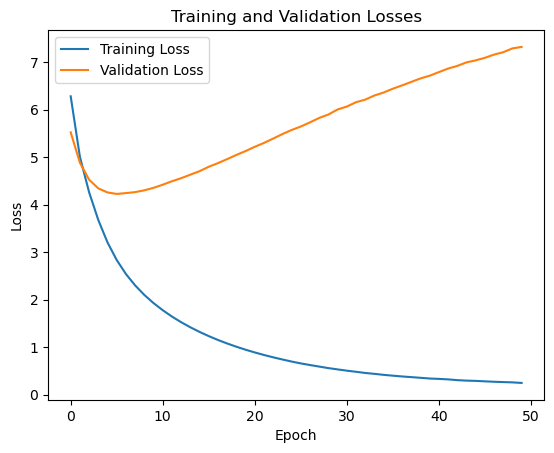

In [45]:

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [46]:
# Save encoder and decoder models
torch.save(model.encoder.state_dict(), 'encoder.pth')
torch.save(model.decoder.state_dict(), 'decoder.pth')


In [47]:
#  new instances 
new_encoder = EncoderLSTM(input_dim, emb_dim, hidden_dim,n_layers)
new_decoder = DecoderLSTM(output_dim, emb_dim, hidden_dim,n_layers)

new_encoder.load_state_dict(torch.load('encoder.pth'))
new_decoder.load_state_dict(torch.load('decoder.pth'))


<All keys matched successfully>

In [137]:
model.eval()  
example_index = 10



for batch_idx, (source_seq, target_seq) in enumerate(val_loader):
    if batch_idx == example_index:
        source_seq = source_seq
        target_seq = target_seq
        break  
    
    print("Source sequence:", source_seq.shape)
    print("Target sequence:", target_seq.shape) 
    predicted_tokens_per_batch = []
    
    for i in range(source_seq_val.size(0)):  #
        #print("Sentence ", i)
        source_seq_val_i = source_seq_val[20].unsqueeze(0)  # Take one sentence from the batch
        target_seq_val_i = target_seq_val[20].unsqueeze(0)  # take one sentence , uncomment to loop
        #print("source_seq_val_i", source_seq_val_i.shape)
        #print("target_seq_val_i", target_seq_val_i.shape)
        #stop
        encoder_outputs_val, hidden_val, cell_val = new_encoder(source_seq_val_i)
        #("Shapes: ", encoder_outputs_val.shape, hidden_val.shape, cell_val.shape)

        batch_size_val = source_seq_val_i.size(0)
        #target_seq_val_i = target_seq_val_i[:, :-1]
        #input_seq_val = target_seq_val_i[:, 1:]

        predicted_tokens = []
        attn_plot = [] 
        for t in range(target_seq_val_i.size(1)):  # Iterate over each time step
            #print("Sequence ", t)
            decoder_output_val, hidden_val, cell_val, attention_weights = new_decoder(target_seq_val_i[:, t], hidden_val, cell_val, encoder_outputs_val)

            # Add an outer dimension to the decoder output
            decoder_output_val = decoder_output_val.unsqueeze(1)
            predicted_token_index = torch.argmax(decoder_output_val, dim=-1)
            attn_plot.append(attention_weights.detach().numpy().reshape(-1 , )) 
            if predicted_token_index == PAD_TOKEN:
                break
            predicted_tokens.append(predicted_token_index.item())

        predicted_tokens_per_batch.append(predicted_tokens)
        break   # uncomment to process further 

    
    #print("Predicted tokens for batch:", predicted_tokens_per_batch)
    break  # uncomment to process further 

Source sequence: torch.Size([128, 20])
Target sequence: torch.Size([128, 20])


In [133]:
attention_weights.shape

torch.Size([1, 20])

In [138]:
source_sentence = [english_idx2word[idx] for idx in source_seq_val_i.squeeze(0).tolist() ] #if idx != PAD_TOKEN
print("Source sequence:", source_sentence)

reference_translation = [french_idx2word[idx] for idx in target_seq_val_i.squeeze(0).tolist() ] #if idx != PAD_TOKEN
print("reference_translation:", reference_translation)


predicted_translation = []
for idx in predicted_tokens:
    if idx == PAD_TOKEN:
        break  
    predicted_translation.append(french_idx2word[idx])

print("Predicted translation:", predicted_translation)



Source sequence: ['canadian', 'association', 'of', 'university', 'research', 'administrators', 'caura', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
reference_translation: ['<sos>', '•', 'association', 'des', 'bibliothèques', 'de', 'recherche', 'du', 'canada', 'abrc', '<eos>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Predicted translation: ['•', 'association', 'des', 'universités', 'universitaires', 'recherche', 'en', 'cnrc', 'pièce', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>']


In [126]:
split_predicted_translation = [word.split() for word in predicted_translation]


split_source_sentence = [word.split() for word in source_sentence]

print(split_predicted_translation)

print(split_source_sentence)

[['les'], ['titre'], ['et'], ['territoires'], ['il'], ['la'], ['assurée'], ['provinces'], ['et'], ['territoires'], ['territoires'], ['appliquent'], ['doit'], ['<eos>'], ['<eos>'], ['<eos>'], ['<eos>'], ['<eos>'], ['<eos>'], ['<eos>']]
[['the'], ['provinces'], ['and'], ['territories'], ['are'], ['responsible'], ['for'], ['all'], ['levels'], ['of'], ['education'], ['including'], ['universities'], ['<PAD>'], ['<PAD>'], ['<PAD>'], ['<PAD>'], ['<PAD>'], ['<PAD>'], ['<PAD>']]


In [127]:
len(split_source_sentence), len(split_predicted_translation), 

(20, 20)

In [72]:
import seaborn as sns


In [128]:
def plot_attention(attention , sent , pred_sent) : 
    plt.figure(figsize=(20,20))
    plt.rcParams['font.size'] = 7
    g = sns.heatmap(attention, annot=True, fmt='.2f')
    g.set_xticklabels(sent)
    g.set_yticklabels(pred_sent)
    plt.show()

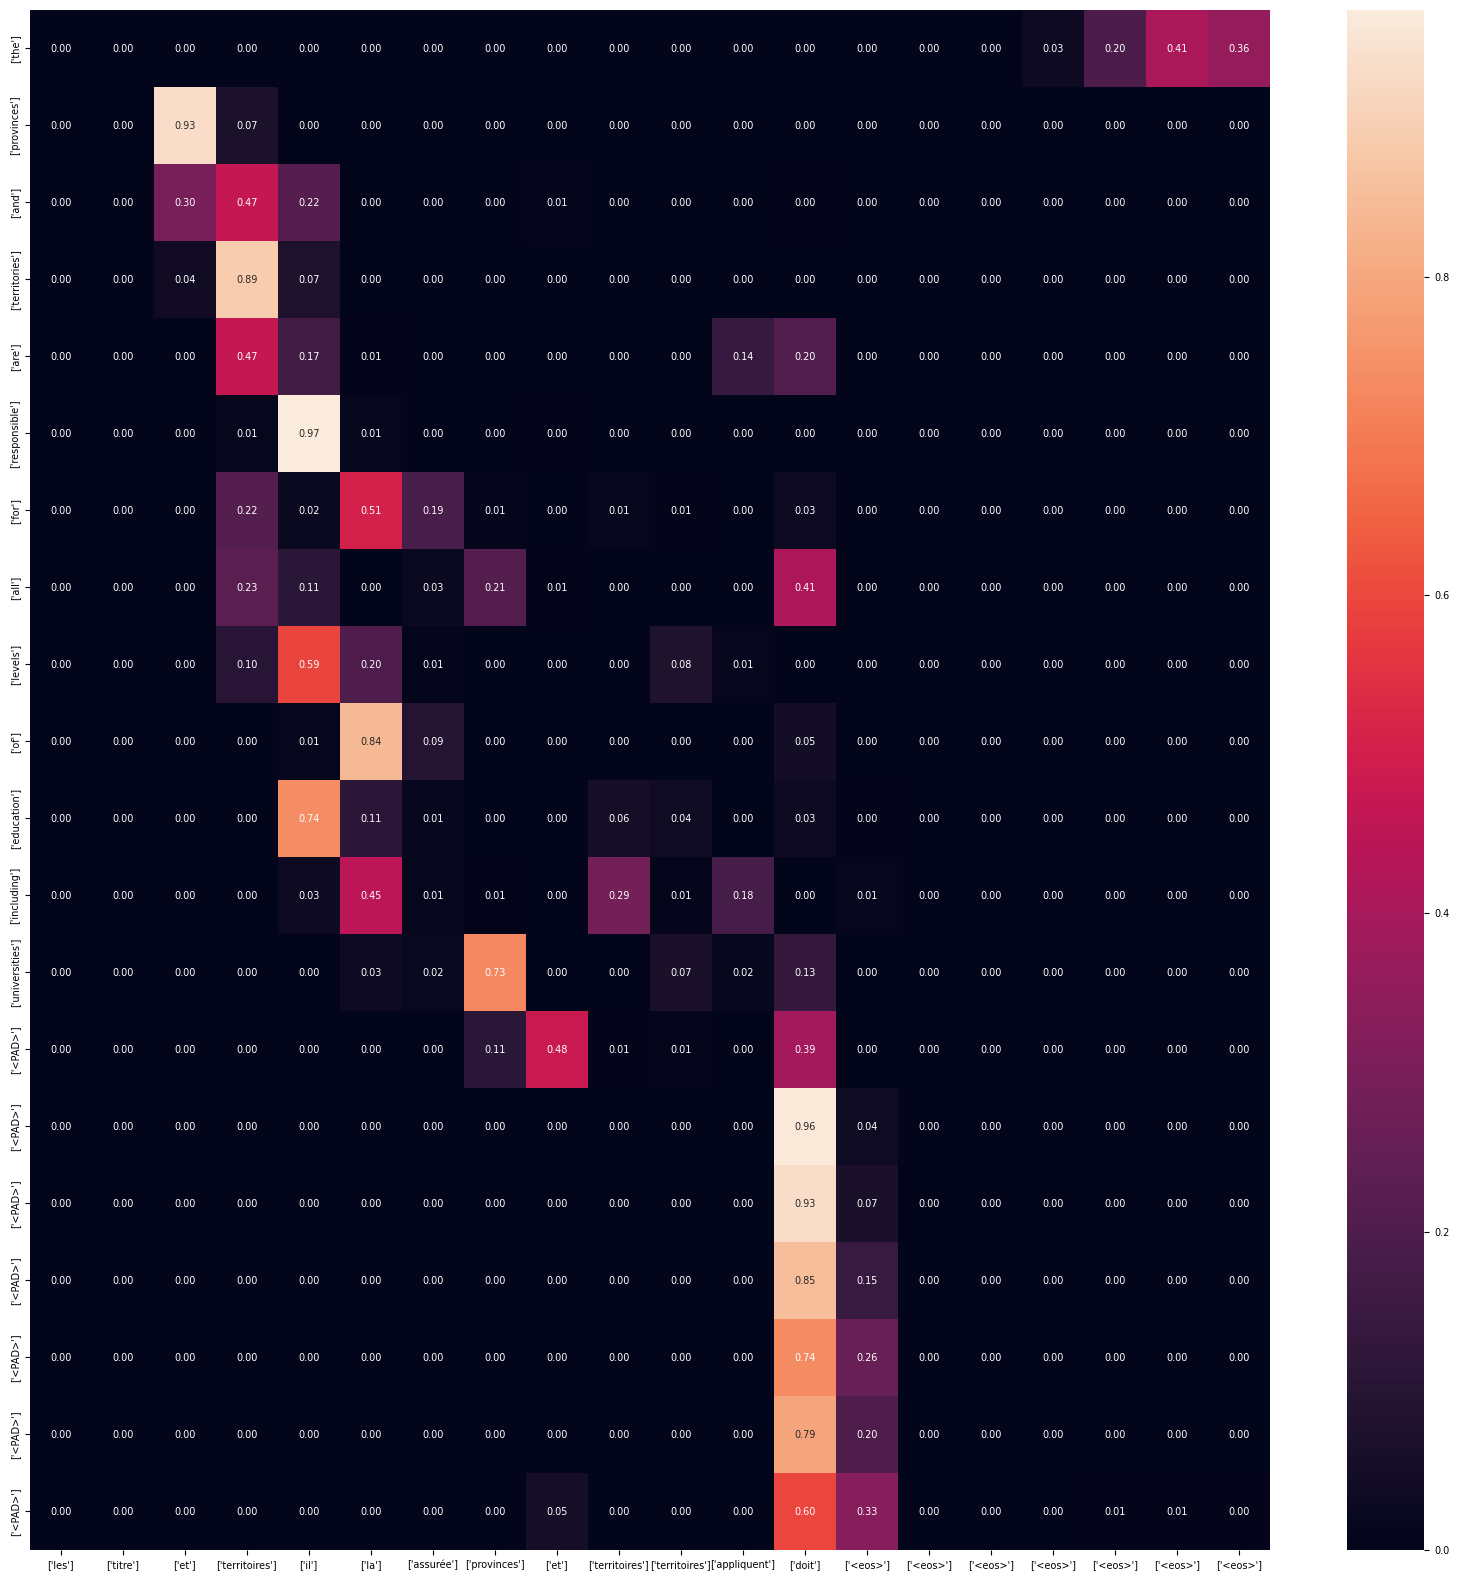

In [106]:
plot_attention(attn_plot, split_predicted_translation, split_source_sentence)

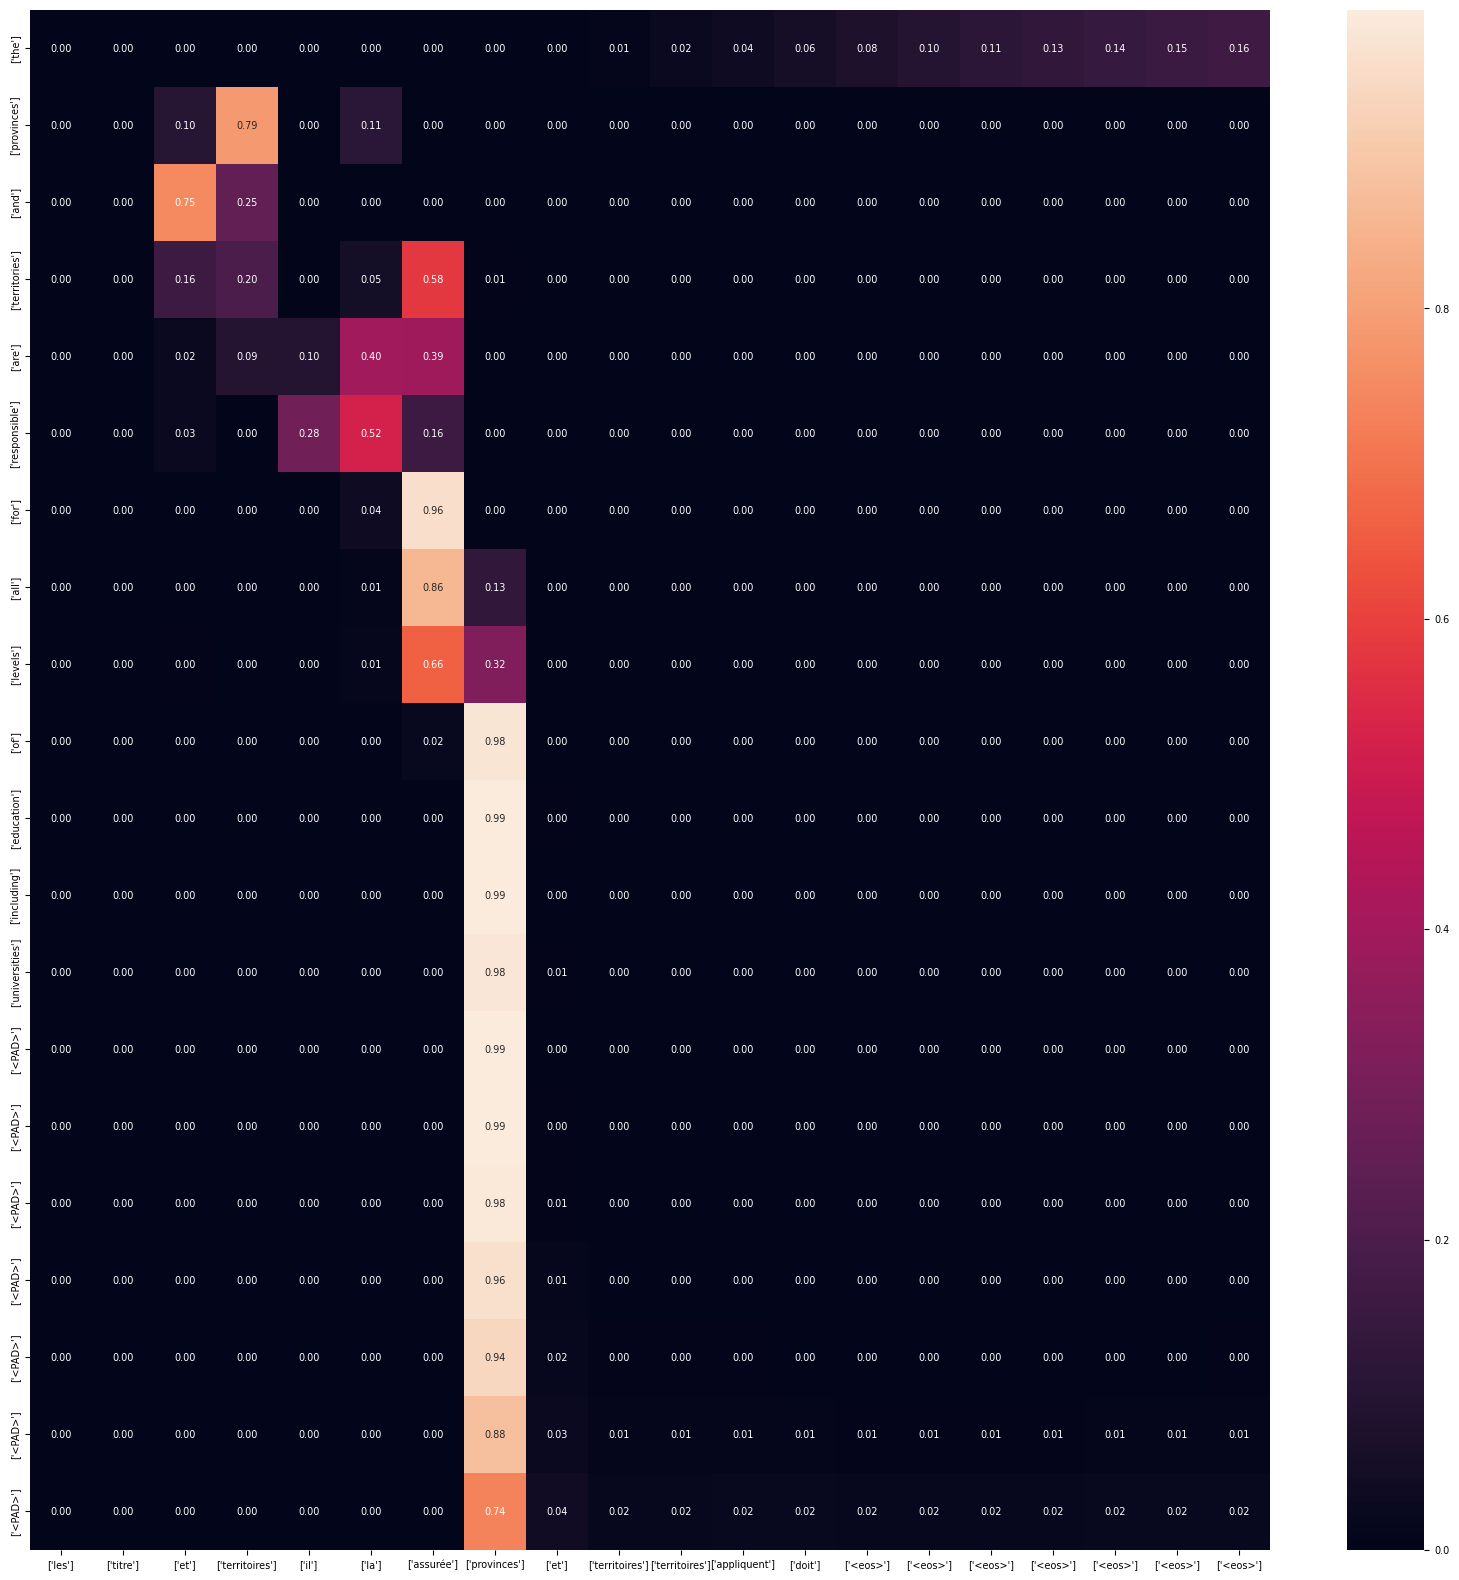

In [139]:
plot_attention(attn_plot, split_predicted_translation, split_source_sentence)

In [434]:
import torch
from nltk.translate.bleu_score import sentence_bleu

def calculate_bleu_score(predicted_indices, target_indices):
    
    predicted_tokens = predicted_indices.tolist() 
    target_tokens = target_indices.tolist()
    
    PAD_TOKEN = 0
    
    #  for each sequence pair
    bleu_scores = []
    for pred_seq, target_seq in zip(predicted_tokens, target_tokens):
        # to lists
        pred_seq = pred_seq if isinstance(pred_seq, list) else [pred_seq]
        target_seq = target_seq if isinstance(target_seq, list) else [target_seq]
        
        # remove padding tokens
        pred_seq = [token for token in pred_seq if token != PAD_TOKEN]
        target_seq = [token for token in target_seq if token != PAD_TOKEN]
        
        #  BLEU score
        bleu_score = sentence_bleu([target_seq], pred_seq)
        bleu_scores.append(bleu_score)
    
    #  average BLEU score
    avg_bleu_score = sum(bleu_scores) / len(bleu_scores)
    return avg_bleu_score


In [ ]:
# Evaluation
encoder.eval()
decoder.eval()
total_bleu_score = 0

with torch.no_grad():
    for batch_idx, (source_seq, target_seq) in enumerate(val_loader):
        encoder_outputs, hidden, cell = encoder(source_seq)
        batch_size = source_seq.size(0)
        output_seq = target_seq[:, :-1]  # exclude <EOS> token
        input_seq = target_seq[:, 1:]    # exclude <SOS> token
        output, _, _ = decoder(input_seq, hidden, cell)
        output_dim = output.size(-1)
        output = output.contiguous().view(-1, output_dim)
        target_seq = output_seq.contiguous().view(-1)
        predicted_indices = torch.argmax(output, dim=1)
        target_indices = target_seq
        
        #BLEU score 
        bleu_score = calculate_bleu_score(predicted_indices, target_indices)
        
        total_bleu_score += bleu_score
        
        print(f"Batch {batch_idx + 1}/{len(val_loader)} - BLEU Score: {bleu_score:.4f}")

#average BLEU score
avg_bleu_score = total_bleu_score / len(val_loader)

# Print average BLEU score for the entire validation set
print(f"Validation BLEU Score: {avg_bleu_score:.4f}")


# Inference
# You can use the trained model for translating new English sentences to French
# by passing them through the encoder and decoder
